# The World Factbook by CIA Analysis

In this notebook, I'm going to work on Factbook data which contains demographic information for each country in the world, including as of 2015.

The dataset is stored in SQLite file called [factbook.db](factbook.db) which you may download if you wish. Having the file is SQLite format means that we'll need to use a SQL related Python module, sqlite3 which is very similar to other SQL modules from functions perspective.

The goal of this notebook is to show you how to use SQL capabilities in Python and vice-versa.

#### Import Data and Return Columns via SQL

In [1]:
import sqlite3

conn = sqlite3.connect("factbook.db")
c = conn.cursor()

c.execute("PRAGMA TABLE_INFO(facts)")

[col for col in c.fetchall()]

[(0, 'id', 'INTEGER', 1, None, 1),
 (1, 'code', 'varchar(255)', 1, None, 0),
 (2, 'name', 'varchar(255)', 1, None, 0),
 (3, 'area', 'integer', 0, None, 0),
 (4, 'area_land', 'integer', 0, None, 0),
 (5, 'area_water', 'integer', 0, None, 0),
 (6, 'population', 'integer', 0, None, 0),
 (7, 'population_growth', 'float', 0, None, 0),
 (8, 'birth_rate', 'float', 0, None, 0),
 (9, 'death_rate', 'float', 0, None, 0),
 (10, 'migration_rate', 'float', 0, None, 0),
 (11, 'created_at', 'datetime', 0, None, 0),
 (12, 'updated_at', 'datetime', 0, None, 0)]

#### Return Sample Row

In [2]:
c.execute("SELECT * FROM FACTS LIMIT 1")

[line for line in c.fetchall()]

[(1,
  'af',
  'Afghanistan',
  652230,
  652230,
  0,
  32564342,
  2.32,
  38.57,
  13.89,
  1.51,
  '2015-11-01 13:19:49.461734',
  '2015-11-01 13:19:49.461734')]

#### Cleaning and Enriching Data with Pandas

In [3]:
import pandas as pd
import math

pd.set_option('display.float_format',lambda x: '%.3f' % x)  ## This would remove the math scientific notation from numbers
df = pd.read_sql_query("SELECT * FROM facts",con=conn)

df = df[df["area_land"] != 0]

#Negate rates which should be nagative
def growth_rate_correction(x):
    if x["death_rate"] > x["birth_rate"]:
        return -1 * x["population_growth"]
    else:
        return x["population_growth"]

df["corrected_population_growth"] = df[["birth_rate","death_rate","population_growth"]].apply(growth_rate_correction,axis=1)

#### Population Projection 2020-2100

In [4]:
def projected_pop(row,in_years):
    N = row["population"] * math.pow(math.e, (row["corrected_population_growth"]/100) * in_years)
    return N

df["in_2020"] = df[["population","corrected_population_growth"]].apply(lambda x: projected_pop(x,5),axis=1)
df["in_2025"] = df[["population","corrected_population_growth"]].apply(lambda x: projected_pop(x,10),axis=1)
df["in_2030"] = df[["population","corrected_population_growth"]].apply(lambda x: projected_pop(x,15),axis=1)
df["in_2035"] = df[["population","corrected_population_growth"]].apply(lambda x: projected_pop(x,20),axis=1)
df["in_2040"] = df[["population","corrected_population_growth"]].apply(lambda x: projected_pop(x,25),axis=1)
df["in_2045"] = df[["population","corrected_population_growth"]].apply(lambda x: projected_pop(x,30),axis=1)
df["in_2050"] = df[["population","corrected_population_growth"]].apply(lambda x: projected_pop(x,35),axis=1)
df["in_2100"] = df[["population","corrected_population_growth"]].apply(lambda x: projected_pop(x,85),axis=1)

df[["name","population","in_2020","in_2025","in_2030","in_2035","in_2040","in_2045",
   "in_2050","in_2100"]][df["name"].isin( ["Japan","India","United Arab Emirates"])]

,name,population,in_2020,in_2025,in_2030,in_2035,in_2040,in_2045,in_2050,in_2100
76,India,1251695584.000,1330425877.127,1414108220.204,1503054091.798,1597594562.137,1698081525.407,1804889009.556,1918414568.486,3530710407.721
84,Japan,126919659.000,125908352.348,124905103.874,123909849.369,122922525.137,121943067.988,120971415.237,120007504.698,110780889.276
183,United Arab Emirates,5779760.000,6575575.872,7480967.730,8511023.106,9682906.934,11016147.592,12532962.322,14258627.460,51798550.142


#### Plotting Population Projection for Japan, India and UAE

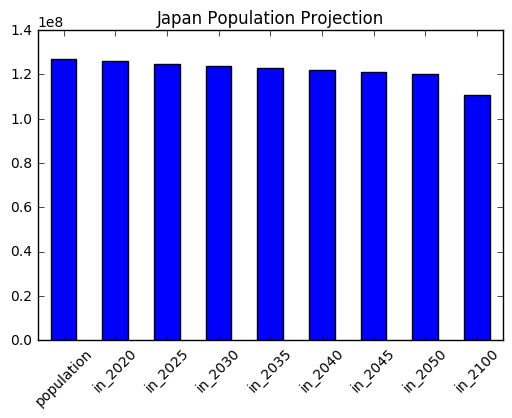

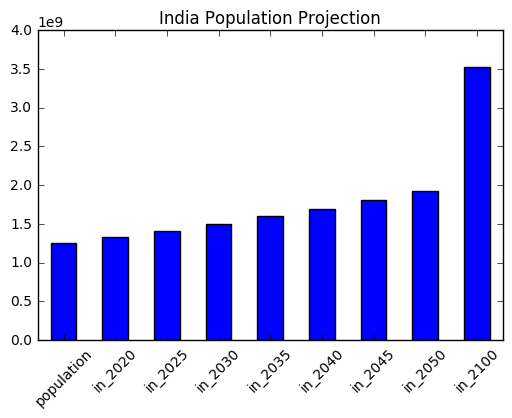

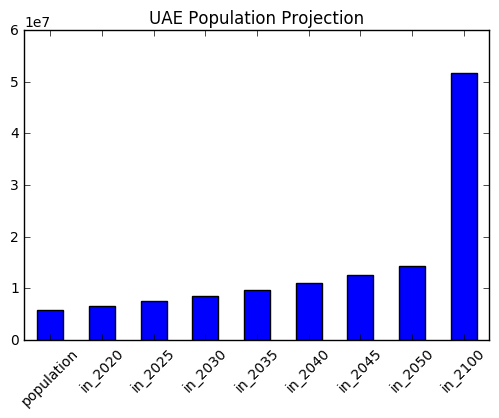

In [5]:
import matplotlib.pyplot as plt

uae_population_projection = df[["population","in_2020","in_2025","in_2030","in_2035","in_2040","in_2045",
   "in_2050","in_2100"]][df["name"] == "Japan"].squeeze()

uae_population_projection.plot(kind="bar")
plt.xticks(rotation=45)

plt.title("Japan Population Projection")
plt.show()

uae_population_projection = df[["population","in_2020","in_2025","in_2030","in_2035","in_2040","in_2045",
   "in_2050","in_2100"]][df["name"] == "India"].squeeze()

uae_population_projection.plot(kind="bar")
plt.xticks(rotation=45)

plt.title("India Population Projection")
plt.show()

uae_population_projection = df[["population","in_2020","in_2025","in_2030","in_2035","in_2040","in_2045",
   "in_2050","in_2100"]][df["name"] == "United Arab Emirates"].squeeze()

uae_population_projection.plot(kind="bar")
plt.xticks(rotation=45)

plt.title("UAE Population Projection")
plt.show()

#### Which countries will lose population over the next 35 years?

In [6]:
losing_population = df[["name","population","in_2030","in_2050","in_2100"]][df["in_2050"] < df["population"]]

losing_population

,name,population,in_2030,in_2050,in_2100
9,Austria,8665550.000,7979337.555,7148162.959,5429545.316
15,Belarus,9589689.000,9306270.858,8941366.758,8090483.211
21,Bosnia and Herzegovina,3867055.000,3792377.896,3695046.857,3462508.185
25,Bulgaria,7186893.000,6588060.202,5866504.379,4389691.496
43,Croatia,4464844.000,4378622.930,4266245.964,3997760.284
46,Czech Republic,10644842.000,10392407.127,10065114.706,9291271.914
56,Estonia,1265420.000,1165213.210,1043837.768,792870.070
64,Germany,80854408.000,78818686.356,76183896.265,69975844.593
66,Greece,10775643.000,10759491.652,10737994.173,10684438.204
74,Hungary,9897541.000,9576252.563,9164032.788,8209453.388


#### Which countries have the lowest population density?

In [7]:
df["pop_density"] = df["population"] / df["area"]

df[df["in_2050"] < df["population"]][["name","pop_density"]].sort("pop_density",ascending=True)[:10]

/Users/iHijazi/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


,name,pop_density
142,Russia,8.330
213,Saint Pierre and Miquelon,23.376
56,Estonia,27.979
95,Latvia,30.759
101,Lithuania,44.172
15,Belarus,46.193
25,Bulgaria,64.817
182,Ukraine,73.614
21,Bosnia and Herzegovina,75.533
43,Croatia,78.893


#### Which countries have the highest population density?

In [8]:
df[df["in_2050"] < df["population"]][["name","pop_density"]].sort("pop_density",ascending=False)[:10]

/Users/iHijazi/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,name,pop_density
116,Monaco,15267.500
84,Japan,335.842
64,Germany,226.469
82,Italy,205.267
46,Czech Republic,134.972
138,Poland,123.326
139,Portugal,117.551
74,Hungary,106.393
115,Moldova,104.778
9,Austria,103.320


#### Average Population, Population Growth, Birth Rate and Death Rate using SQL

In [9]:
result = c.execute("SELECT AVG(population), AVG(population_growth), AVG(birth_rate), AVG(death_rate) FROM facts").fetchone()
print("Average Population: ", result[0])
print("Average Population Growth: ", result[1])
print("Average Birth Rate: ", result[2])
print("Average Death Rate: ", result[3])

Average Population:  62094928.32231405
Average Population Growth:  1.2009745762711865
Average Birth Rate:  19.32855263157894
Average Death Rate:  7.8212719298245625


#### Lowest Population using SQL

In [10]:
result = c.execute("SELECT name, population FROM facts WHERE population > 0 ORDER BY population ASC")
                   
result.fetchmany(5)

[('Pitcairn Islands', 48),
 ('Cocos (Keeling) Islands', 596),
 ('Holy See (Vatican City)', 842),
 ('Niue', 1190),
 ('Tokelau', 1337)]

#### Highest Population

In [11]:
result = c.execute("SELECT name, population FROM facts WHERE population > 0 ORDER BY population DESC")

result.fetchmany(5)

[('World', 7256490011),
 ('China', 1367485388),
 ('India', 1251695584),
 ('European Union', 513949445),
 ('United States', 321368864)]

#### Lowest Birth Rate

In [12]:
result = c.execute("SELECT name, birth_rate from facts where birth_rate > 0 ORDER BY birth_rate ASC")

result.fetchmany(5)

[('Monaco', 6.65),
 ('Saint Pierre and Miquelon', 7.42),
 ('Japan', 7.93),
 ('Andorra', 8.13),
 ('Korea, South', 8.19)]

#### Highest Birth Rate

In [13]:
result = c.execute("SELECT name, birth_rate FROM facts WHERE birth_rate > 0 ORDER BY birth_rate DESC")

result.fetchmany(5)

[('Niger', 45.45),
 ('Mali', 44.99),
 ('Uganda', 43.79),
 ('Zambia', 42.13),
 ('Burkina Faso', 42.03)]

#### Lowest Death Rate

In [14]:
result = c.execute("SELECT name, death_rate FROM facts WHERE death_rate > 0 ORDER BY death_rate ASC")

result.fetchmany(5)

[('Qatar', 1.53),
 ('United Arab Emirates', 1.97),
 ('Kuwait', 2.18),
 ('Bahrain', 2.69),
 ('Gaza Strip', 3.04)]

#### Highest Death Rate

In [15]:
result = c.execute("SELECT name, death_rate FROM facts WHERE death_rate > 0 ORDER BY death_rate DESC")

print(result.fetchmany(5))

conn.close()

[('Lesotho', 14.89), ('Ukraine', 14.46), ('Bulgaria', 14.44), ('Guinea-Bissau', 14.33), ('Latvia', 14.31)]


#### Export Data to CSV

In [16]:
df.to_csv("factbook.csv")

# That's it
--

But many more questions can be asked, why don't you try it yourself? If you wish to download the exported CSV file, [click here](factbook.csv)

Prepared by Issam Hijazi
https://ae.linkedin.com/in/ihijazi
@iHijazi